In [34]:
import torch
import pathpyG as pp
from collections import defaultdict

from torch_geometric.utils import cumsum, coalesce, degree, sort_edge_index
from torch_geometric.data import Data

pp.config['torch']['device'] = 'cpu'

In [8]:
tedges = [('a', 'b', 1), ('b', 'c', 5), ('c', 'd', 9), ('c', 'e', 9),
              ('c', 'f', 11), ('f', 'a', 13), ('a', 'g', 18), ('b', 'f', 21),
              ('a', 'g', 26), ('c', 'f', 27), ('h', 'f', 27), ('g', 'h', 28),
              ('a', 'c', 30), ('a', 'b', 31), ('c', 'h', 32), ('f', 'h', 33),
              ('b', 'i', 42), ('i', 'b', 42), ('c', 'i', 47), ('h', 'i', 50)]
t = pp.TemporalGraph.from_edge_list(tedges)
print(t.mapping)
print(t.N)
print(t.M)

a -> 0
b -> 1
c -> 2
d -> 3
e -> 4
f -> 5
g -> 6
h -> 7
i -> 8

9
20


In [75]:
tedges = [('a', 'b', 1),('a', 'b', 2), ('b', 'a', 3), ('b', 'c', 3), ('d', 'c', 4),
              ('c', 'd', 5), ('c', 'b', 6)]
t = pp.TemporalGraph.from_edge_list(tedges)
print(t.mapping)
print(t.N)
print(t.M)

a -> 0
b -> 1
c -> 2
d -> 3

4
7


In [33]:
m = pp.MultiOrderModel.from_temporal_graph(t, max_order=4, delta=2)
print(m.layers[2])
for i, e in enumerate(m.layers[2].edges):
    print(e, m.layers[2].data.edge_weight[i])

Directed graph with 6 nodes and 5 edges

Node attributes
	node_sequence		<class 'torch.Tensor'> -> torch.Size([6, 2])

Edge attributes
	edge_weight		<class 'torch.Tensor'> -> torch.Size([5])

Graph attributes
	num_nodes		<class 'int'>

(('a', 'b'), ('b', 'a')) tensor(2.)
(('a', 'b'), ('b', 'c')) tensor(2.)
(('b', 'c'), ('c', 'd')) tensor(1.)
(('d', 'c'), ('c', 'b')) tensor(1.)
(('d', 'c'), ('c', 'd')) tensor(1.)


In [52]:
# Solution 1 -> slow
def temporal_shortest_paths(g: pp.TemporalGraph, delta, max_k) -> defaultdict:
    """
    Calculates all shortest paths between all pairs of nodes 
    based on a set of empirically observed paths.
    """
    sp = defaultdict(lambda: defaultdict(set))
    sp_lengths = torch.full((g.N, g.N), float('inf'))
    sp_lengths.fill_diagonal_(float(0))
    out_degree=degree(g.data.edge_index[0],num_nodes=g.N)
    in_degree =degree(g.data.edge_index[1],num_nodes=g.N)

    sp_lengths[out_degree==0]=0
    sp_lengths[:,in_degree==0]=0
    print(sp_lengths)

    # first-order edge index
    edge_index, timestamps = sort_edge_index(g.data.edge_index, g.data.t)
    node_sequence = torch.arange(g.data.num_nodes, device=edge_index.device).unsqueeze(1)
    k = 1
    while torch.max(sp_lengths) > k and edge_index.size(1)>0 and k < max_k:

        print(f'k = {k}, edge_index size = {edge_index.size(1)}')
        #print(f'node_sequences = {node_sequences}')
        # check for shorter paths with length k
        src, tgt = edge_index
        for i in range(edge_index.size(1)):
            u = node_sequence[src[i]][0]
            v = node_sequence[tgt[i]][-1]
            if k < sp_lengths[u][v]:
                path = torch.cat([node_sequence[src[i]], v.unsqueeze(dim=0)])
                sp_lengths[u][v] = k
                sp[u][v] = set([g.mapping.to_id(x.item()) for x in path])
            elif k == sp_lengths[u][v]:
                path = torch.cat([node_sequence[src[i]], v.unsqueeze(dim=0)])
                sp[u][v].add(tuple([g.mapping.to_id(x.item()) for x in path]))
                 

        if k==1:
            null_model_edge_index = pp.MultiOrderModel.lift_order_edge_index(edge_index, num_nodes=node_sequence.size(0))
            # Update node sequences
            node_sequence = torch.cat([node_sequence[edge_index[0]], node_sequence[edge_index[1]][:, -1:]], dim=1)
            # Remove non-time-respecting higher-order edges
            time_diff = timestamps[null_model_edge_index[1]] - timestamps[null_model_edge_index[0]]
            non_negative_mask = time_diff > 0
            delta_mask = time_diff <= delta
            time_respecting_mask = non_negative_mask & delta_mask
            edge_index = null_model_edge_index[:, time_respecting_mask]
        else:
            edge_index, node_sequence, _, _ = pp.MultiOrderModel.iterate_lift_order(edge_index, node_sequence, mapping=g.mapping)
        k += 1
    return sp_lengths, sp


In [120]:
# Solution 2
def routes_from_node(g, v):
        """
        Constructs all paths from node v to any leaf nodes

        Parameters
        ----------
        v:
            node from which to start
        node_mapping: dict
            an optional mapping from node to a different set.

        Returns
        -------
        list
            a list of lists, where each list contains one path from the source
            node v until a leaf node is reached
        """
        # Collect temporary paths, indexed by the target node
        temp_paths = defaultdict(list)
        temp_paths[v] = [[v]]

        # set of unprocessed nodes
        queue = {v}

        while queue:
            # take one unprocessed node
            x = queue.pop()

            # successors of x expand all temporary
            # paths, currently ending in x
            s = g.get_successors(x)
            for w in s:
                w = w.item()
                for p in temp_paths[x]:
                    temp_paths[w].append(p + [w])
                queue.add(w)
            if len(s)>0:
                del temp_paths[x]
        paths = []
        for x in temp_paths:
             for p in temp_paths[x]:
                paths.append(p)
        return paths

def temporal_shortest_paths(g: pp.TemporalGraph, delta) -> defaultdict:
    """
    Calculates all shortest paths between all pairs of nodes 
    based on a set of empirically observed paths.
    """
    sp = defaultdict(lambda: defaultdict(set))
    sp_lengths = torch.full((g.N, g.N), float('inf'))
    sp_lengths.fill_diagonal_(float(0))
    out_degree=degree(g.data.edge_index[0],num_nodes=g.N)
    in_degree =degree(g.data.edge_index[1],num_nodes=g.N)

    sp_lengths[out_degree==0]=0
    sp_lengths[:,in_degree==0]=0
    print(sp_lengths)

    # first-order edge index
    edge_index, timestamps = sort_edge_index(g.data.edge_index, g.data.t)
    node_sequence = torch.arange(g.data.num_nodes, device=edge_index.device).unsqueeze(1)
    k = 1

    # second-order edge index
    null_model_edge_index = pp.MultiOrderModel.lift_order_edge_index(edge_index, num_nodes=node_sequence.size(0))
    # Update node sequences
    node_sequence = torch.cat([node_sequence[edge_index[0]], node_sequence[edge_index[1]][:, -1:]], dim=1)
    # Remove non-time-respecting higher-order edges
    time_diff = timestamps[null_model_edge_index[1]] - timestamps[null_model_edge_index[0]]
    non_negative_mask = time_diff > 0
    delta_mask = time_diff <= delta
    time_respecting_mask = non_negative_mask & delta_mask
    edge_index = null_model_edge_index[:, time_respecting_mask]
    
    # identify ndoes with in-degree zero
    in_degree = degree(edge_index[1],num_nodes=g.M)
    roots = torch.where(in_degree==0)[0]
    event_dag = pp.Graph.from_edge_index(edge_index)
    print(event_dag)
    print(roots.size(0))
    paths = []
    i = 0
    for r in roots:
        print(f'root {i}')
        p = routes_from_node(event_dag, r.item())
        paths += p
        i += 1
    print(len(paths))
    mapped_paths = []
    for p in paths:
        mp = [ g.mapping.to_id(node_sequence[p[0]][0].item()) ]
        mp += [ g.mapping.to_id(node_sequence[p[i]][-1].item()) for i in range(0, len(p))]
        
        mapped_paths.append(mp)
    print(mapped_paths)
    return sp_lengths, sp


In [109]:
sp_lengths, sp = temporal_shortest_paths(t, delta=100, max_k=20)
print(sp_lengths)
print(sp)

tensor([[0., inf, inf, inf],
        [inf, 0., inf, inf],
        [inf, inf, 0., inf],
        [inf, inf, inf, 0.]])
tensor([0, 1, 6])
2
3
4
5
2
3
4
5
4
5
[('a', 'b', 'a'), ('a', 'b', 'c', 'b'), ('a', 'b', 'c', 'd'), ('a', 'b', 'a'), ('a', 'b', 'c', 'b'), ('a', 'b', 'c', 'd'), ('d', 'c', 'b'), ('d', 'c', 'd')]
tensor([[0., inf, inf, inf],
        [inf, 0., inf, inf],
        [inf, inf, 0., inf],
        [inf, inf, inf, 0.]])
defaultdict(<function temporal_shortest_paths.<locals>.<lambda> at 0x7f039da635b0>, {})


In [111]:
t = pp.TemporalGraph.from_csv('ants_1_1.tedges')
print(t)

Temporal Graph with 89 nodes, 947 unique edges and 1911 events in [0.0, 1438.0]

Graph attributes
	dst		<class 'torch.Tensor'> -> torch.Size([1911])
	src		<class 'torch.Tensor'> -> torch.Size([1911])
	t		<class 'torch.Tensor'> -> torch.Size([1911])



/opt/conda/lib/python3.10/site-packages/torch_geometric/data/storage.py:450: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'dst', 'src', 't'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(


In [121]:
sp_lengths, sp = temporal_shortest_paths(t, delta=30)
print(sp_lengths)

tensor([[0., inf, inf,  ..., inf, inf, inf],
        [inf, 0., inf,  ..., inf, inf, inf],
        [inf, inf, 0.,  ..., inf, inf, inf],
        ...,
        [inf, inf, inf,  ..., 0., inf, inf],
        [inf, inf, inf,  ..., inf, 0., inf],
        [inf, inf, inf,  ..., inf, inf, 0.]])
Directed graph with 1910 nodes and 2518 edges

Graph attributes
	num_nodes		<class 'int'>

597
root 0
root 1
root 2
root 3
root 4
root 5
root 6
root 7
root 8
root 9
root 10
root 11
root 12
root 13
root 14
root 15
root 16
root 17
root 18
root 19
root 20
root 21
root 22
root 23
root 24
root 25
root 26
root 27
root 28
root 29
root 30
root 31
root 32
root 33
root 34
root 35
root 36
root 37
root 38
root 39
root 40
root 41
root 42
root 43
root 44
root 45
root 46
root 47
root 48
root 49
root 50
root 51
root 52
root 53
root 54
root 55
root 56
root 57
root 58
root 59
root 60
root 61
root 62
root 63
root 64
root 65
root 66
root 67
root 68
root 69
root 70
root 71
root 72
root 73
root 74
root 75
root 76
root 77
root 78

KeyboardInterrupt: 

In [47]:
torch.max(sp_lengths[sp_lengths < 100])

tensor(13.)

(array([1036.,  365.,  184.,  182.,   41.,   21.,   22.,    5.,    2.,
           4.]),
 array([ 0.        ,  1.29999995,  2.5999999 ,  3.9000001 ,  5.19999981,
         6.5       ,  7.80000019,  9.10000038, 10.39999962, 11.69999981,
        13.        ]),
 <BarContainer object of 10 artists>)

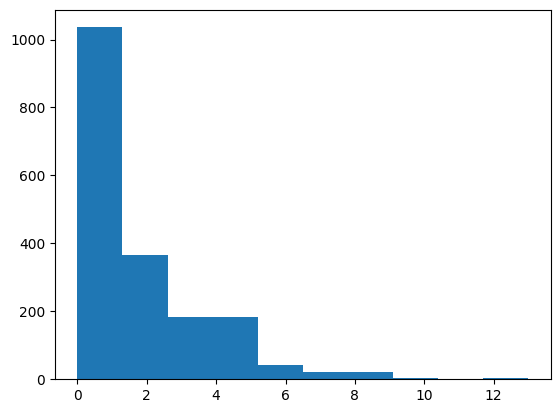

In [48]:
plt.hist(sp_lengths[sp_lengths < 100].flatten().numpy())

In [37]:
from matplotlib import pyplot as plt

In [49]:
a = torch.tensor([0,1,2])
b = torch.tensor([1,2,3])
torch.cat([a, b[-1].unsqueeze(dim=0)])

tensor([0, 1, 2, 3])

In [64]:
for x in torch.tensor([0,1]):
    print(x.item())

0
1
